# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,108
Number of N/A: 17


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9108, minmax=(25, 5585), mean=512.50614844093104, variance=132895.07441041915, skewness=2.165082161250325, kurtosis=9.675609846339958)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Workspace/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

Toy Story (1995)

A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worry about Andy's family moving, and what Woody does not know is about Andy's birthday party. Woody does not realize that Andy's mother gave him an action figure known as Buzz Lightyear, who does not believe that he is a toy, and quickly becomes Andy's new favorite toy. Woody, who is now consumed with jealousy, tries to get rid of Buzz. Then, both Woody and Buzz are now lost. They must find a way to get back to Andy before he moves without them, but they will have to pass through a ruthless toy killer, Sid Phillips.

['a', 'little', 'boy', 'named', 'andy', 'loves', 'to', 'be', 'in', 'his', 'room', ',', 'playing', 'with', 'his', 'toys', ',', 'especially', 'his', 'doll', 'named', '``', 'woody', "''", '.', 'but', ',', 'what', 'do

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

42086

Documents size:

9108

Most common words (+UNK):

[(',', 47938), ('the', 45433), ('.', 35269), ('a', 27780), ('to', 26522)]

Document example: id=1

Toy Story (1995) 

A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worry about Andy's family moving, and what Woody does not know is about Andy's birthday party. Woody does not realize that Andy's mother gave him an action figure known as Buzz Lightyear, who does not believe that he is a toy, and quickly becomes Andy's new favorite toy. Woody, who is now consumed with jealousy, tries to get rid of Buzz. Then, both Woody and Buzz are now lost. They must find a way to get back to Andy before he moves without them, but they will have to pass through a ruthless toy killer, Sid Phillips. 

[4, 183, 173, 144, 1325, 494, 5, 35, 

In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (183, little) -> (4, a)
0: (183, little) -> (173, boy)
0: (173, boy) -> (144, named)
0: (173, boy) -> (183, little)
0: (144, named) -> (1325, andy)
0: (144, named) -> (173, boy)
0: (1325, andy) -> (144, named)
0: (1325, andy) -> (494, loves)
0: (494, loves) -> (5, to)
0: (494, loves) -> (1325, andy)

2nd Batch:

0: (5, to) -> (494, loves)
0: (5, to) -> (35, be)
0: (35, be) -> (8, in)
0: (35, be) -> (5, to)
0: (8, in) -> (10, his)
0: (8, in) -> (35, be)
0: (10, his) -> (8, in)
0: (10, his) -> (483, room)
0: (483, room) -> (10, his)
0: (483, room) -> (1, ,)

3rd Batch:

0: (1, ,) -> (649, playing)
0: (1, ,) -> (483, room)
0: (649, playing) -> (1, ,)
0: (649, playing) -> (13, with)
0: (13, with) -> (10, his)
0: (13, with) -> (649, playing)
0: (10, his) -> (13, with)
0: (10, his) -> (5027, toys)
0: (5027, toys) -> (1, ,)
0: (5027, toys) -> (10, his)


In [8]:
import tensorflow as tf

tf.__version__

'1.1.0'

In [9]:
import os
import shutil

class Paragraph2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width),
            name='docs_embeddings')
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width),
            name='words_embeddings')
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, global_step=global_step, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss, global_step=global_step)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, embeddings, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(words_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, embeddings, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Paragraph2vecTrainer:
    
    #corpus
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate,
                 logdir='log/paragraph2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        self.logdir = logdir
    
    def remove_log(self):
        if os.path.isdir(self.logdir):
            shutil.rmtree(self.logdir)
    
    def train(self, num_epochs=1, delay_lr_decay=0, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.train, model.loss]
                average_loss = 0
            
                step = 0
                last_epoch = data_reader.num_epoch
                while data_reader.num_epoch < num_epochs:
                    batch_docs, batch_data, batch_labels = data_reader.read()
                    feed_dict = {
                        model.input_docs: batch_docs,
                        model.input_data: batch_data,
                        model.input_labels: batch_labels,
                    }
                
                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 5000 == 0:
                        if step > 0:
                            average_loss /= 5000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0
                                
                    step += 1
                
                    if data_reader.num_epoch != last_epoch:
                        last_epoch = data_reader.num_epoch

                        lr = model.lr(session)
                        if last_epoch >= delay_lr_decay:
                            model.assign_lr(session, max(0.001, lr / 2))
                    
                        print()
                        print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                        print()
                        doc_query.run(session)
                        word_query.run(session)
                        print()

                print('Total steps: {:,d}'.format(step))
            
                docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Paragraph2vecModel(self.corpus.documents_size,
                                  self.corpus.vocabulary_size,
                                  self.embedding_size,
                                  self.num_sampled,
                                  self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model.words_embeddings, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model.docs_embeddings, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)

In [10]:
%%time

trainer = Paragraph2vecTrainer(
    train_corpus,
    batch_size = 125,
    skip_window = 5,       # How many words to consider left and right.
    num_skips = 5,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 25,      # Number of negative examples to sample.
    learning_rate = 0.5)   # Initial learning rate.

docs_embeddings = trainer.train(num_epochs=25, delay_lr_decay=10)
# docs_embeddings = trainer.train(num_epochs=1)

INFO:tensorflow:global_step/sec: 0
Average loss at step 0: 122.438
Average loss at step 5,000: 50.422
Average loss at step 10,000: 26.552
Average loss at step 15,000: 18.548
Average loss at step 20,000: 14.439
Average loss at step 25,000: 12.048
Average loss at step 30,000: 10.554

Epoch 1 (lr=0.50000)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of war for fifteen years. When their hotel-bound bus crashes in a mountain storm and Joan is injured, the travellers seek refuge in the home, built fortress-like upon the site of a bloody battlefield, of famed architect Hjalmar Poelzig. There, cat-phobic Verdegast learns his wife's fate, grieves for his lost daughter, and must play a game of chess for Allison's life.

[ 1, 0.985 ] Dick Tracy (1990)

All Tess Trueheart wants is to settle down to a quiet lif

Average loss at step 110,000: 4.339
Average loss at step 115,000: 4.289
Average loss at step 120,000: 4.257
Average loss at step 125,000: 4.224
Average loss at step 130,000: 4.197

Epoch 4 (lr=0.50000)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of war for fifteen years. When their hotel-bound bus crashes in a mountain storm and Joan is injured, the travellers seek refuge in the home, built fortress-like upon the site of a bloody battlefield, of famed architect Hjalmar Poelzig. There, cat-phobic Verdegast learns his wife's fate, grieves for his lost daughter, and must play a game of chess for Allison's life.

[ 1, 0.927 ] Chaos (2005)

Two cops, a rookie and a grizzled vet, pursue an accomplished bank robber.

[ 2, 0.927 ] Nazarin (Nazarín) (1959)

A priest in a poor community lives a charitable l

Nearest to angharad: adoptive (0.973), shallow (0.972), *^r (0.972), monsignor (0.972), midget (0.972), twenty-three (0.972), tessa (0.971), eragon (0.971)
Nearest to morales: kato (0.989), ramírez (0.988), esai (0.988), nic (0.988), mackie (0.988), tessa (0.988), all-gay (0.987), naomi (0.987)
Nearest to swampers: kyuta (0.992), cybernetic (0.992), ghraib (0.992), yoo (0.992), sledge (0.992), hesitantly (0.992), freehauf (0.992), apollos (0.992)

INFO:tensorflow:global_step/sec: 381.923
Average loss at step 235,000: 3.968
Average loss at step 240,000: 3.952
Average loss at step 245,000: 3.942
Average loss at step 250,000: 3.946
Average loss at step 255,000: 3.952
Average loss at step 260,000: 3.931

Epoch 8 (lr=0.50000)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of war for fifteen years. When th

Nearest to angharad: single-parenting (0.973), fleur (0.973), royce (0.972), twenty-three (0.972), khatchadourian (0.971), gabato (0.971), irfan (0.969), young-shin (0.969)
Nearest to morales: ramírez (0.973), confidant (0.973), esai (0.973), 'shazza (0.972), dirkman (0.972), 'zeke (0.972), speed-chess (0.972), aimes (0.971)
Nearest to swampers: bucket (0.990), ghraib (0.990), paisley (0.990), ecole (0.990), wainwright (0.990), gaye (0.990), yoo (0.990), howlin (0.990)

Average loss at step 365,000: 3.356
Average loss at step 370,000: 3.267
INFO:tensorflow:global_step/sec: 387.27
Average loss at step 375,000: 3.289
Average loss at step 380,000: 3.272
Average loss at step 385,000: 3.273
Average loss at step 390,000: 3.254
Average loss at step 395,000: 3.227

Epoch 12 (lr=0.12500)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended b

Nearest to angharad: single-parenting (0.973), fleur (0.973), royce (0.972), twenty-three (0.972), gabato (0.971), khatchadourian (0.970), less-than-perfect (0.970), irfan (0.970)
Nearest to morales: confidant (0.972), 'shazza (0.972), esai (0.971), ramírez (0.971), speed-chess (0.971), 'zeke (0.970), dirkman (0.970), coulson (0.970)
Nearest to swampers: bucket (0.990), ghraib (0.990), paisley (0.990), wainwright (0.990), yoo (0.989), dialects (0.989), howlin (0.989), gaye (0.989)

Average loss at step 495,000: 3.069
Average loss at step 500,000: 3.084
Average loss at step 505,000: 3.094
Average loss at step 510,000: 3.101
Average loss at step 515,000: 3.096
Average loss at step 520,000: 3.093
Average loss at step 525,000: 3.073

Epoch 16 (lr=0.00781)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of

Nearest to angharad: single-parenting (0.973), fleur (0.972), royce (0.971), twenty-three (0.971), gabato (0.971), khatchadourian (0.970), less-than-perfect (0.970), irfan (0.969)
Nearest to morales: confidant (0.972), 'shazza (0.971), esai (0.971), ramírez (0.971), speed-chess (0.970), 'zeke (0.970), dirkman (0.970), coulson (0.970)
Nearest to swampers: bucket (0.990), ghraib (0.990), paisley (0.990), wainwright (0.990), yoo (0.989), dialects (0.989), howlin (0.989), gaye (0.989)

Average loss at step 630,000: 3.063
Average loss at step 635,000: 3.074
Average loss at step 640,000: 3.098
Average loss at step 645,000: 3.086
Average loss at step 650,000: 3.080
Average loss at step 655,000: 3.077

Epoch 20 (lr=0.00100)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of war for fifteen years. When their h

Nearest to angharad: single-parenting (0.973), fleur (0.972), royce (0.971), twenty-three (0.971), gabato (0.971), khatchadourian (0.970), less-than-perfect (0.970), irfan (0.969)
Nearest to morales: confidant (0.972), 'shazza (0.971), esai (0.971), ramírez (0.971), speed-chess (0.970), 'zeke (0.970), dirkman (0.970), coulson (0.970)
Nearest to swampers: bucket (0.990), ghraib (0.990), paisley (0.990), wainwright (0.990), yoo (0.989), dialects (0.989), howlin (0.989), gaye (0.989)

Average loss at step 760,000: 3.056
Average loss at step 765,000: 3.065
Average loss at step 770,000: 3.095
Average loss at step 775,000: 3.088
Average loss at step 780,000: 3.083
Average loss at step 785,000: 3.078
Average loss at step 790,000: 3.050

Epoch 24 (lr=0.00100)

Black Cat, The (1934)

Honeymooning in Hungary, Joan and Peter Allison share their train compartment with Dr. Vitus Verdegast, a courtly but tragic man who is returning to the remains of the town he defended before becoming a prisoner of

In [11]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 2min 57s, sys: 34.4 s, total: 3min 31s
Wall time: 3min 29s


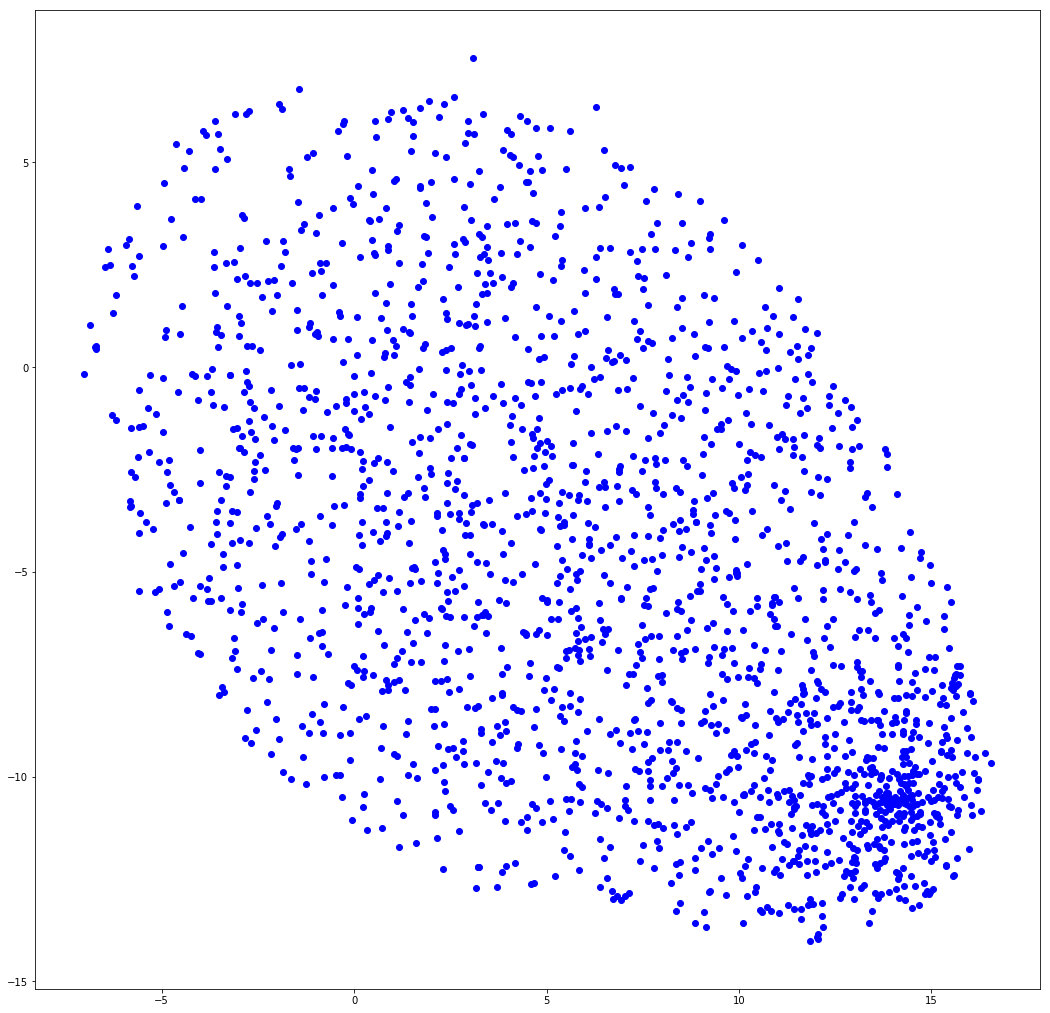

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()

### Content-based User-Item: Avarage with Time Decay

In [13]:
import collections
import csv

MovieWatch = collections.namedtuple('MovieWatch', ['movie_id', 'timestamp'])

users = collections.defaultdict(list)
with open('movielens/ml-latest-small/ratings.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for user_id, item_id, _, timestamp in reader:
        users[user_id].append(MovieWatch(item_id, int(timestamp)))

len(users)

671

In [14]:
from scipy import stats

watch_counts = list(len(movies) for movies in users.values())
stats.describe(watch_counts)

DescribeResult(nobs=671, minmax=(20, 2391), mean=149.03725782414307, variance=53465.901594857292, skewness=4.544628118876829, kurtosis=28.187338511028905)

In [15]:
user_items = dict()
for user, movies in users.items():
    items = list()
    movies = sorted(movies, key=lambda m: int(m.timestamp))
    for movie_id, _ in movies:
        if movie_id not in train_corpus.document_to_idx:
            continue
        i = train_corpus.document_to_idx[movie_id]
        items.append(i)
    user_items[user] = items

stats.describe(list(len(items) for items in user_items.values()))

DescribeResult(nobs=671, minmax=(20, 2390), mean=149.01043219076007, variance=53439.171532797991, skewness=4.543824643860777, kurtosis=28.17625406587097)

In [16]:
class Recommender:
    
    def __init__(self, item_embeddings, user_items, mapping, decay):
        self.item_embeddings = item_embeddings
        n_items = item_embeddings.shape[0]
        
        self.user_items = user_items
        self.user_u = dict()
        self.user_t = collections.defaultdict(int)
        self.user_h = collections.defaultdict(lambda: np.zeros(n_items))
        
        self.mapping = mapping
        self.decay = decay
    
    def user_vec(self, user_id, t):
        items = self.user_items[user_id]
        
        if t >= len(items):
            return self.user_u[user_id], self.user_h[user_id]
        
        i = items[t]
        v = self.item_embeddings[i]
        if t == 0:
            u = v
        else:
            u = v + self.decay * self.user_u[user_id]
            u = u / np.linalg.norm(u)
        self.user_u[user_id] = u
        h = self.user_h[user_id]
        h[i] = 1
        
        return u, h
        
    def recommend(self, user_id, k=3):
        if user_id not in self.user_items:
            return None
        
        t = self.user_t[user_id]
        self.user_t[user_id] += 1
        
        u, h = self.user_vec(user_id, t)
        
        d = np.dot(self.item_embeddings, u)
        d = np.multiply(d, 1 - h)
        rank = d.argsort()[::-1][:k]
        
        return list(self.mapping.document_from_idx[i] for i in rank)

In [17]:
user_id, items = list(user_items.items())[0]

print('{} (movies = {:,d})'.format(user_id, len(items)))
print()

rec = Recommender(docs_embeddings, user_items, train_corpus, 0.8)

for k, last_item in enumerate(items):
    print(train_corpus.title_from_idx(last_item))
    rec_items = rec.recommend(user_id)
    if k < len(items) - 10:
        continue
    print()
    for i, item_id in enumerate(rec_items):
        print('[ {} ] {}'.format(i+1, train_corpus.title_from_id(item_id)))
    print()

1 (movies = 20)

Antz (1998)
Fly, The (1986)
Blazing Saddles (1974)
Dracula (Bram Stoker's Dracula) (1992)
Cape Fear (1991)
Star Trek: The Motion Picture (1979)
Tron (1982)
Dangerous Minds (1995)
Gandhi (1982)
Deer Hunter, The (1978)
Dumbo (1941)

[ 1 ] Snow Walker, The (2003)
[ 2 ] Dylan Moran Live: What It Is (2009)
[ 3 ] Ricky Gervais Live: Animals (2003)

Sleepers (1996)

[ 1 ] W. (2008)
[ 2 ] I Know That Voice (2013)
[ 3 ] Snow Walker, The (2003)

Escape from New York (1981)

[ 1 ] Fled (1996)
[ 2 ] Approaching the Unknown (2016)
[ 3 ] Imagine: John Lennon (1988)

Ben-Hur (1959)

[ 1 ] Fled (1996)
[ 2 ] For the Love of Benji (1977)
[ 3 ] Ricky Gervais Live 3: Fame (2007)

French Connection, The (1971)

[ 1 ] Mummy's Hand, The (1940)
[ 2 ] Hearts and Minds (1974)
[ 3 ] Fled (1996)

Gods Must Be Crazy, The (1980)

[ 1 ] Richard Pryor: Live in Concert (1979)
[ 2 ] 3 Extremes (Three... Extremes) (Saam gaang yi) (2004)
[ 3 ] George Carlin: Life Is Worth Losing (2005)

Willow (1988)

[ 